In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import shap




# Loading clean data

In [ ]:
import os
clean_files = ['../data/cleaned_data/all_dataset.parquet']
dfs = []
for file in clean_files:
    dfs.append(pd.read_parquet(file))
df = pd.concat(dfs, axis = 0)
df.index = pd.to_datetime(df.index)

In [5]:
df['state_of_charge_percent'] = df['state_of_charge_percent'].clip(0,140)
all_ids = df.battery_id.unique()

# Histogram clustering

The idea is to cluster fields (here after "power_out") according to their distribution, approximated by its histogram.

In [6]:
n_bins = 20 # number of bins to split the field in

In [7]:
max_power = df['power_out'].quantile(0.99)
min_power = 0
df['binned_power'] = pd.cut(df['power_out'], np.linspace(min_power,max_power,n_bins))
# count number of times we see a value in the bucket
df_quants = df.groupby(['battery_id','binned_power'])['power_out'].count().unstack('binned_power')
# divides by the number of observation per battery to end up with a frequency
df_quants = df_quants.div(df_quants.sum(axis = 1), axis = 0)

C:\Users\PC_victor\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


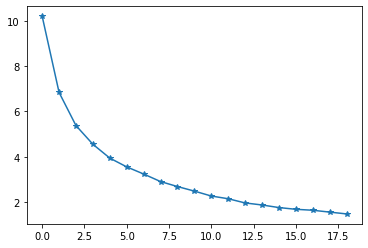

In [10]:
# apply KMean model with K cluster and check inertia
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_quants.values)
    distortions.append(kmeanModel.inertia_)

plt.plot(distortions, marker = '*')

According to the elbow method, a reasonable number of cluster to choose is 3 or 4.

Now predit cluster with Kmeans method. Then, fit a Classifier what will aim to predict class, starting from the input data. It will help us understand the sensibility of each parameter to class determination.

In [13]:
n_clusters = 4
kmeanModel = KMeans(n_clusters=n_clusters)
# predict class
y=kmeanModel.fit(df_quants.values).labels_

# fit a Classifier
clf=RandomForestClassifier()
clf.fit(df_quants.values,y)

RandomForestClassifier()

plot 0


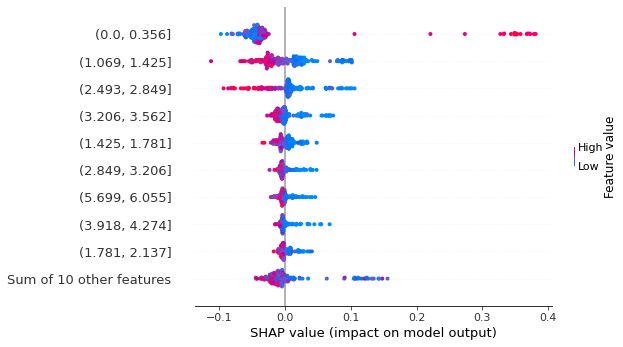

plot 1


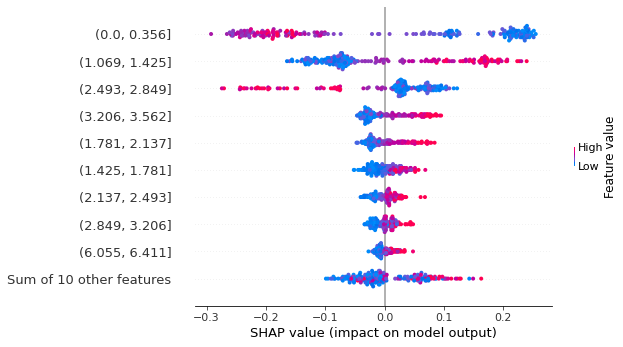

plot 2


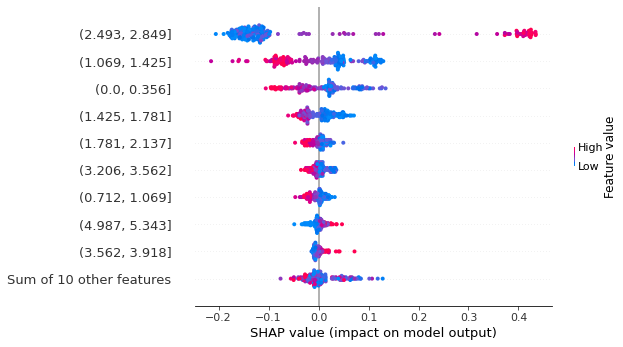

plot 3


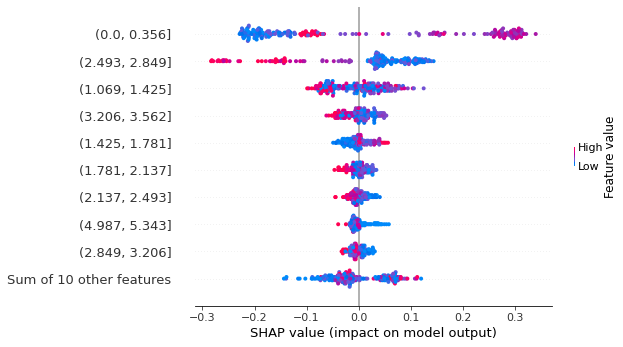

In [15]:
# plot shap values
explainer= shap.TreeExplainer(clf)
shap_values = explainer(df_quants)

for k in range(n_clusters):
    print(f'plot {k}')
    shap.plots.beeswarm(shap_values[:,:,k])

We can interpret those results as the following. For each graph, shap values represent "feature importance". For cluster 1 (1 graph) we can see than important features playing in favor of belonging to cluster 1 is high observation frequency in the first bin, and low frequency of observations in other bins. 

Let's find this result back by plotting the distribution of each class.

<AxesSubplot:xlabel='binned_power', ylabel='n_count'>

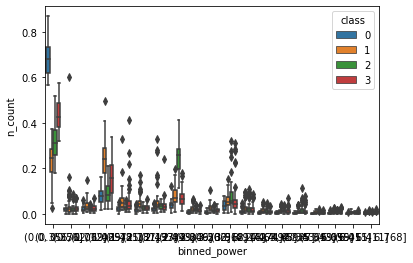

In [17]:
id_to_class = pd.DataFrame(data = y, index = df_quants.index, columns = ['class']).squeeze().to_dict()
df_quants = df_quants.stack()
df_quants = df_quants.rename('n_count')
df_quants = df_quants.reset_index()
df_quants['class'] = df_quants['battery_id'].map(id_to_class)
sns.boxplot(data = df_quants, x = 'binned_power', y = 'n_count', hue = 'class')

# Clustering histogram by power and time

for sake of simplicity when should stick with clustering on the all year.
BUT we loose temporal information. can we have that?

Yes, instead of clustring only power, one cluster power and time.

In [18]:
max_power = df['power_out'].quantile(0.99)
min_power = 0
df['binned_power'] = pd.cut(df['power_out'], np.linspace(min_power,max_power,10))
df['month'] = df.index.month

df_quants_power = df.groupby(['battery_id','binned_power'])['power_out'].count().unstack('binned_power')
df_counts = df_quants_power.sum(axis = 1)

df_quants_hour = df.groupby(['battery_id','hour','binned_power'])['power_out'].count()

In [19]:
X_pca = df_quants_hour.unstack('binned_power').unstack('hour')

Now one can perform a PCA to reduce the dimensionality of the problem

In [20]:
feature_names = X_pca.columns.map('{0[0]}_H{0[1]}'.format) 
X_pca_n = X_pca.div(X_pca.sum(axis = 1), axis = 0)

X_pca_n.columns = feature_names
X_pca_n = X_pca_n.apply(lambda x: x.fillna(x.mean()))

Let's take a look at the data.

<AxesSubplot:>

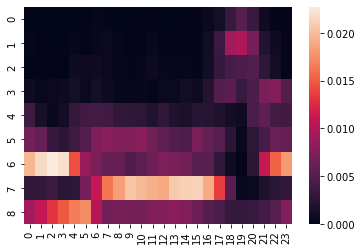

In [24]:
sns.heatmap(np.flip(X_pca_n.loc[3].values.reshape(-1,24), 0))

The PCA

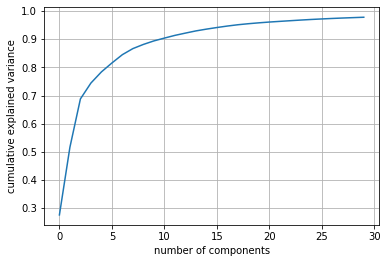

In [99]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_pca_n)

plt.plot(np.cumsum(pca.explained_variance_ratio_)[:30])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid();

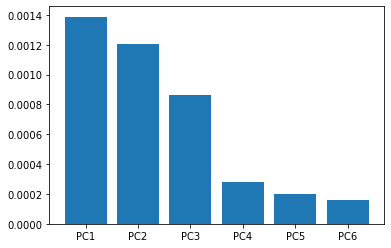

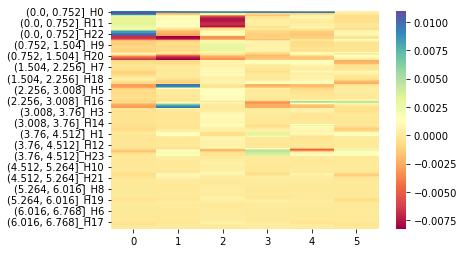

In [101]:
n_components = 6
two_comp_PCA = PCA(n_components=n_components)
X_pca_space = two_comp_PCA.fit_transform(X_pca_n)
plt.bar(x = [f'PC{k}' for k in range(1,n_components+1)], height = two_comp_PCA.explained_variance_)
plt.figure()
plt.plot(np.cumsum(two_comp_PCA.explained_variance_ratio_))
loadings = two_comp_PCA.components_.T * np.sqrt(two_comp_PCA.explained_variance_)

df_loadings = pd.DataFrame(data = loadings, index = feature_names)
ax = sns.heatmap(df_loadings, annot=False, cmap='Spectral')
plt.show()

# Plot points in the PCA space

We chose to keep 6 first dimensions but we will project spaces only on the 3 first principal components

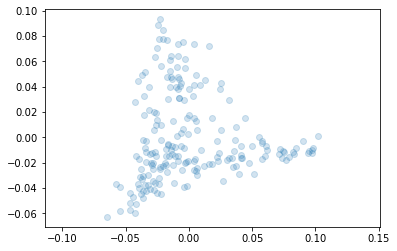

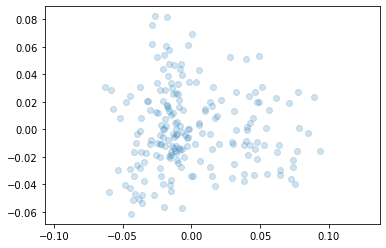

In [103]:
# plot data
plt.scatter(X_pca_space[:, 0], X_pca_space[:, 1], alpha=0.2)
plt.axis('equal');

plt.figure()
plt.scatter(X_pca_space[:, 1], X_pca_space[:, 2], alpha=0.2)
plt.axis('equal');

C:\Users\PC_victor\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


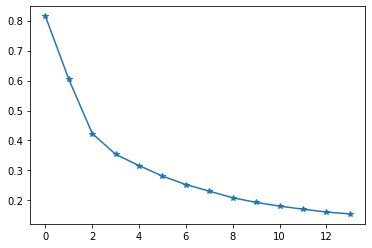

In [105]:
n_components_to_keep = 6
X_clustering = X_pca_space[:,:n_components_to_keep]
from sklearn.cluster import KMeans
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_clustering)
    distortions.append(kmeanModel.inertia_)
plt.plot(distortions, marker = "*")

In [106]:
n_clusters = 4
kmeanModel = KMeans(n_clusters=n_clusters)
y=kmeanModel.fit(X_clustering).labels_

df_X_clsutering = pd.DataFrame(data= X_clustering, index = X_pca.index, columns = [f'PC{k}' for k in range(1,n_components_to_keep+1)])
df_y_clustering = pd.DataFrame(data= y, index = X_pca.index, columns = ['class'])

# Plot data and class

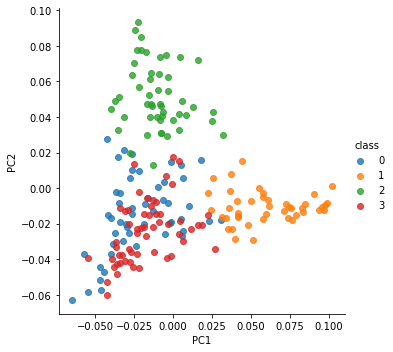

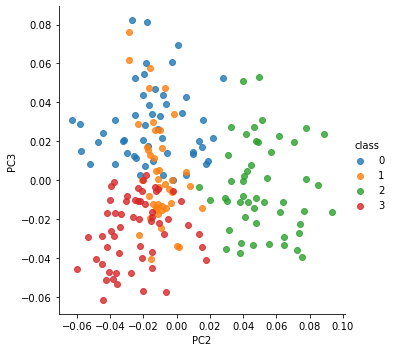

In [109]:
sns.lmplot(data = pd.concat([df_X_clsutering, df_y_clustering], axis = 1), x = 'PC1', y = 'PC2', hue = 'class', fit_reg = False)
sns.lmplot(data = pd.concat([df_X_clsutering, df_y_clustering], axis = 1), x = 'PC2', y = 'PC3', hue = 'class', fit_reg = False)

In [114]:
df_analyse = X_pca_n.copy()

df_analyse = df_analyse.join(df_y_clustering)
std = df_analyse.groupby('class').std()
mean = df_analyse.groupby('class').mean()


# Show clustered profies

Did it cluster correctly ? Let's take a look if clusters make sens

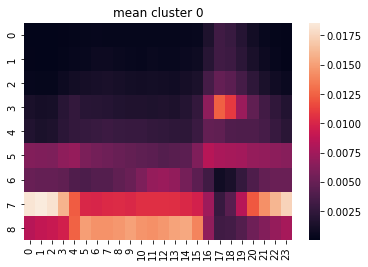

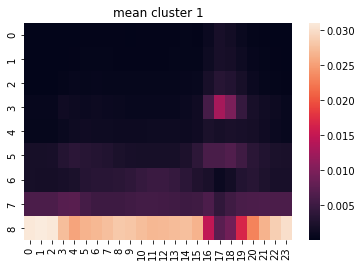

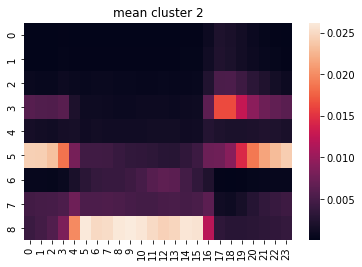

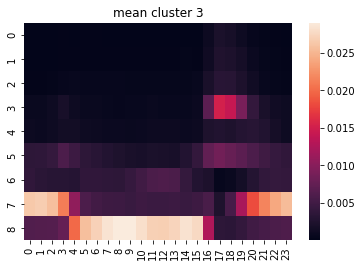

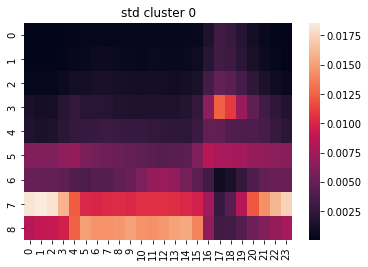

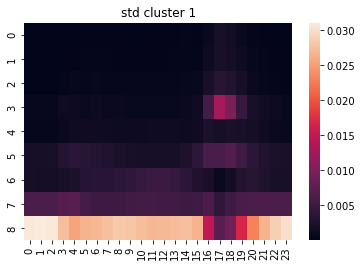

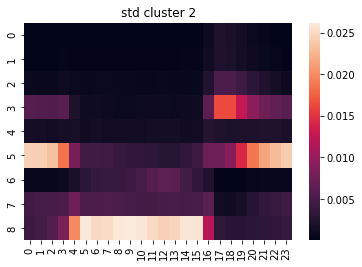

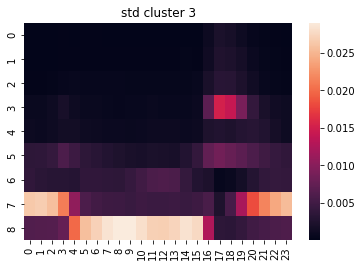

In [121]:
for k in range(n_clusters):
    plt.figure()
    sns.heatmap(np.flip(mean.loc[k].values.reshape(-1,24), 0))
    plt.title(f'mean cluster {k}')